In [1]:
p = 90
N = 15
BATCH_SIZE = 3
CIRCLES_SCALER = BATCH_SIZE * N

In [25]:
import pickle

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

from collections import defaultdict
from pathlib import Path
from sklearn.metrics.pairwise import pairwise_distances
from tqdm.asyncio import tqdm
from string import Template
from joblib import Parallel, delayed
from al_mg_zn import AlMgZnMeltingPoint
des = AlMgZnMeltingPoint()

def maximal_independent_set(D, t):
    adj_matrix = np.array(D <= t, dtype=int)
    np.fill_diagonal(adj_matrix, 0)
    G = nx.from_numpy_array(np.array(adj_matrix))
    return nx.maximal_independent_set(G)

def calc_circles(X, radius):
    if len(X) == 0:
        return 0
    else:
        D = pairwise_distances(X, metric="euclidean")
        # for t in [2**j for j in range(7)]:
        s = maximal_independent_set(D, radius)
        # print(k, t, len(s))
        return len(s)

def get_circles(X, action_idx, threshold_list):
    """並列化されたバージョン - joblibのスレッド並列化を使用（推奨）"""
    return Parallel(n_jobs=-1, backend='threading')(
        delayed(calc_circles)(X, action_idx, t) for t in threshold_list)

def get_circles_process_parallel(X, action_idx, threshold_list):
    """プロセス並列化バージョン（大きなデータセット用）"""
    return Parallel(n_jobs=-1)(delayed(calc_circles)(X, action_idx, t) for t in threshold_list)

def get_circles_sequential(X, action_idx, threshold_list):
    """元のシーケンシャルバージョン（比較用）"""
    return [calc_circles(X, action_idx, t) for t in threshold_list]

# Directory name's template string
dir_template = Template("data_${MODE}_${TRIALS}")
trials_list = [1, 2, 3, 4, 5]
mode_list = ["aggressive", "moderate", "conservative"]
radius_list = np.arange(0, 26, 1)

In [26]:
# データ構造の詳細調査と修正されたデータ読み込み


def collect_near_optimal_samples(samples_dict, objectives_dict, target_threshold, iter_num):
    """
    指定されたイテレーション数まで、target_thresholdを超えるサンプルを収集する関数
    
    Parameters:
    -----------
    samples_dict : dict
        各イテレーションのサンプルデータ
    objectives_dict : dict  
        各イテレーションの目的値データ
    target_threshold : float
        閾値
    iter_num : int
        処理するイテレーション数
    
    Returns:
    --------
    dict : 各イテレーションまでの累積near-optimalサンプル
    int : 見つかったnear-optimalサンプルの総数
    """
    near_optimal_samples_by_iter = defaultdict(list)
    
    for k in range(1, iter_num + 1):
        # near_optimal_samples_by_iter は各イテレーションまでに見つかったnear-optimal samplesを全て保持
        near_optimal_samples_by_iter[k] = near_optimal_samples_by_iter[k-1].copy()
        for sample, obj in zip(samples_dict[k], objectives_dict[k]):
            if obj >= target_threshold:
                near_optimal_samples_by_iter[k].append(sample)
    
    return near_optimal_samples_by_iter

def circles_by_radius(X, radius_list):
    return [calc_circles(X, r) for r in radius_list]

def all_circles(sample_path, objective_path, target_threshold, N):

    with open(sample_path, 'rb') as f:
        samples_dict = pickle.load(f)

    with open(objective_path, 'rb') as f:
        objectives_dict = pickle.load(f)


    # function = Descriptor()
    near_optimal_samples_by_iter = defaultdict(list)
    # kを1から10まで変化させ、target_thresholdを超えたサンプルを

    # 関数を使用
    near_optimal_samples_by_iter = collect_near_optimal_samples(
        samples_dict, objectives_dict, target_threshold, N
    )
    circles = circles_by_radius(near_optimal_samples_by_iter[N], radius_list)
    return circles

def all_max_objective(sample_path, objective_path, N):

    with open(sample_path, 'rb') as f:
        samples_dict = pickle.load(f)

    with open(objective_path, 'rb') as f:
        objectives_dict = pickle.load(f)

    max_objective_list = [max(objectives_dict[1])]
    for k in range(1, N + 1):
        # print(max_objective_list, max(objectives_dict[k]))
        max_objective_list.append(max(max_objective_list[-1], max(objectives_dict[k])))
    return max_objective_list

# target_threshold は function.y の90パーセンタイルに対応
target_threshold = np.percentile(des.y, p)
print(f"Target threshold for {p}% percentile: {target_threshold}")

Target threshold for 90% percentile: 839.985


In [27]:
# まず、1つのイテレーションのデータ構造を詳しく調べる
# mode = "conservative"
trial_list = [1, 2, 3, 4, 5]
# trial_list = [1, 2, 3]
mode_list = ["random", "conservative", "moderate", "aggressive", "physbo"]
mode_to_circles = defaultdict(list)
for mode in mode_list:
    for trial in trial_list:
        data_dir = dir_template.substitute(MODE=mode, TRIALS=trial)
        sample_path = Path(data_dir) / "sample_by_iter.pkl"
        objective_path = Path(data_dir) / "objective_by_iter.pkl"
        print(mode, trial)
        circles = all_circles(sample_path, objective_path, target_threshold, N)
        print(circles)
        mode_to_circles[mode].append([c / CIRCLES_SCALER for c in circles])


random 1
[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
random 2
[13, 13, 10, 6, 6, 4, 3, 3, 3, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
random 3
[4, 4, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
random 4
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
random 5
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
conservative 1
[26, 26, 18, 16, 13, 11, 9, 9, 8, 5, 6, 4, 4, 4, 4, 3, 4, 3, 3, 3, 3, 4, 3, 3, 3, 3]
conservative 2
[24, 24, 16, 11, 10, 7, 6, 7, 6, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
conservative 3
[26, 26, 15, 12, 10, 9, 7, 6, 6, 6, 5, 5, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3]
conservative 4
[21, 21, 18, 15, 12, 10, 11, 9, 8, 8, 7, 6, 4, 4, 5, 4, 4, 4, 4, 3, 4, 3, 4, 3, 3, 3]
conservative 5
[29, 29, 19, 16, 12, 10, 8, 7, 6, 5, 5, 4, 4, 3, 4, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 2]
moderate 1
[28, 28, 21, 16, 12, 11, 9, 7, 7, 6, 5, 5, 5, 5

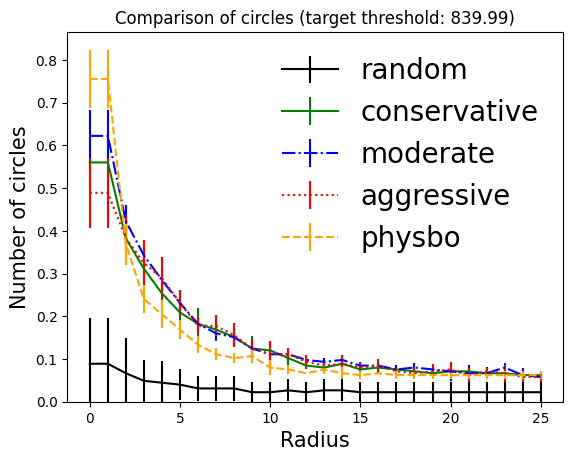

In [28]:
import matplotlib.pyplot as plt

mode_to_style = {
    "random": "-",
    "aggressive": ":",
    "moderate": "-.",
    "conservative": "-",
    "physbo": "--",
}

mode_to_color = {
    "random": "black",
    "aggressive": "red",
    "moderate": "blue",
    "conservative": "green",
    "physbo": "orange",
}

fig, ax = plt.subplots()
tmp = 0
for mode in mode_list:
    mean_circles = np.mean(np.array(mode_to_circles[mode]), axis=0)
    std_circles = np.std(np.array(mode_to_circles[mode]), axis=0)
    tmp = max(mean_circles[0], tmp)
    ax.errorbar(radius_list, mean_circles, yerr=std_circles, label=mode, linestyle=mode_to_style[mode], color=mode_to_color[mode])
ax.set_xlabel("Radius", fontsize=15)
ax.set_ylabel("Number of circles", fontsize=15)
ax.set_title(f"Comparison of circles (target threshold: {target_threshold:.2f})")
# ax.set_ylim(0, 10 * int(tmp / 10) + 20)
ax.set_ylim(0)
# ax.set_yticks([1] + [5, 10, 15, 20, 25, 30, 35, 40])
plt.legend(fontsize=20, frameon=False)
# plt.savefig(f"figures/circles_comparison_{p}percentile_{N}iterations.pdf")

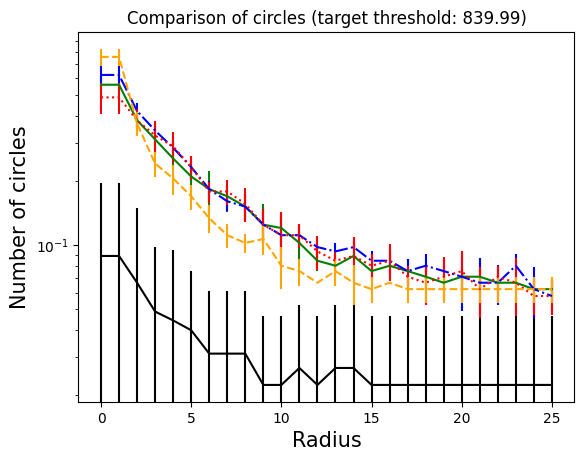

In [29]:
fig, ax = plt.subplots()
tmp = 0
for mode in mode_list:
    mean_circles = np.mean(np.array(mode_to_circles[mode]), axis=0)
    std_circles = np.std(np.array(mode_to_circles[mode]), axis=0)
    tmp = max(mean_circles[0], tmp)
    ax.errorbar(radius_list, mean_circles, yerr=std_circles, label=mode, linestyle=mode_to_style[mode], color=mode_to_color[mode])
ax.set_xlabel("Radius", fontsize=15)
ax.set_ylabel("Number of circles", fontsize=15)
ax.set_title(f"Comparison of circles (target threshold: {target_threshold:.2f})")
# ax.set_ylim(0, 10 * int(tmp / 10) + 20)
# plt.legend(fontsize=25, frameon=False)
ax.set_yscale("log")
# ax.set_ylim(1)
# ax.set_yticks([1, 10])
# plt.savefig(f"figures/circles_comparison_{p}percentile_{N}iterations_log.pdf")

In [14]:
mode_to_objectives = defaultdict(list)
mode_to_regrets = defaultdict(list)
for mode in mode_list:
    for trial in trial_list:
        data_dir = dir_template.substitute(MODE=mode, TRIALS=trial)
        sample_path = Path(data_dir) / "sample_by_iter.pkl"
        objective_path = Path(data_dir) / "objective_by_iter.pkl"
        objectives = all_max_objective(sample_path, objective_path, N)
        mode_to_objectives[mode].append(objectives)
        mode_to_regrets[mode].append([des.get_regret(obj) for obj in objectives])

(0.0, 149.7265801210255)

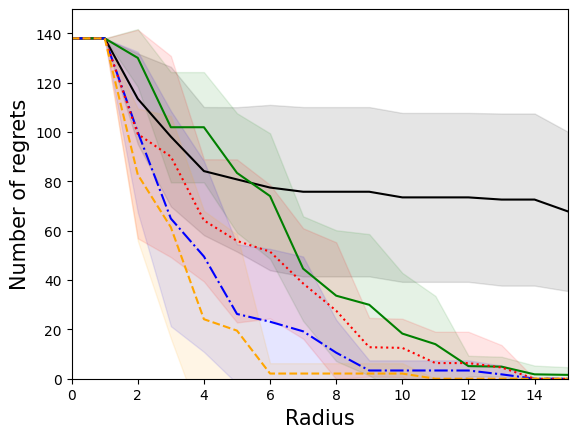

In [15]:
fig, ax = plt.subplots()
for mode in mode_list:
    mean_regrets = np.mean(np.array(mode_to_regrets[mode]), axis=0)
    std_regrets = np.std(np.array(mode_to_regrets[mode]), axis=0)
    # ax.errorbar(np.arange(len(mean_regrets)), mean_regrets, yerr=std_regrets, label=mode, linestyle=mode_to_style[mode], color=mode_to_color[mode])
    ax.plot(np.arange(len(mean_regrets)), mean_regrets, label=mode, linestyle=mode_to_style[mode], color=mode_to_color[mode])
    ax.fill_between(np.arange(len(mean_regrets)), mean_regrets - std_regrets, mean_regrets + std_regrets, alpha=0.1, color=mode_to_color[mode])
ax.set_xlabel("Radius", fontsize=15)
ax.set_ylabel("Number of regrets", fontsize=15)
# ax.set_title(f"target threshold: {target_threshold:.2f} / regret: {des.get_regret(target_threshold):.2f})")
# ax.set_ylim(0, 180)
ax.set_xlim(0, N)
ax.set_ylim(0)
# Move legend outside the plot
# ax.legend(fontsize=25, frameon=False, loc='center left', bbox_to_anchor=(1, 0.5))
# plt.savefig(f"figures/simple_regret.pdf")

In [16]:
# integral under the curve
np.trapz(mean_circles, radius_list)
trapz_dict = defaultdict(list)
for mode in mode_list:
    mode_circles = np.array(mode_to_circles[mode])
    for circles in mode_circles:
        trapz_dict[mode].append(np.trapz(circles, radius_list))
for mode in mode_list:
    print(rf"{mode} & {np.mean(trapz_dict[mode])} \pm {np.std(trapz_dict[mode])}")

random & 3.6288888888888877 \pm 3.16820313602381
conservative & 10.664444444444444 \pm 0.32549297843785546
moderate & 10.428888888888887 \pm 0.9617525155852553
aggressive & 10.188888888888886 \pm 1.1388536579916617
physbo & 10.384444444444444 \pm 0.6892687124951273


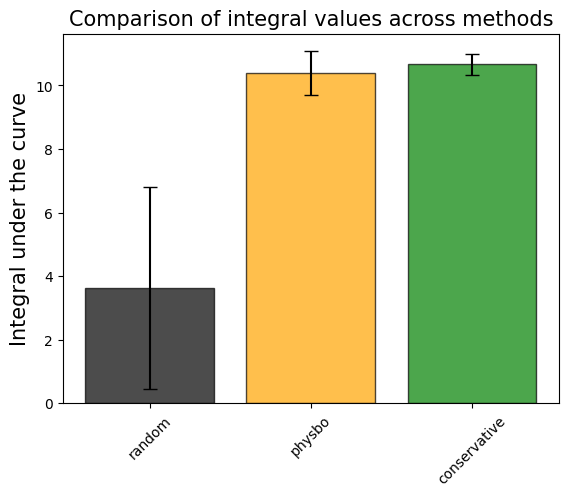

In [17]:
# mode ごとに積分値の平均と分散を棒グラフにする
modes = list(trapz_dict.keys())
modes = ["random", "physbo", "conservative"]
means = [np.mean(trapz_dict[mode]) for mode in modes]
stds = [np.std(trapz_dict[mode]) for mode in modes]

fig, ax = plt.subplots()
bars = ax.bar(modes, means, yerr=stds, capsize=5, 
              color=[mode_to_color[mode] for mode in modes],
              alpha=0.7, edgecolor='black')

# ax.set_xlabel("Method", fontsize=15)
ax.set_ylabel("Integral under the curve", fontsize=15)
ax.set_title("Comparison of integral values across methods", fontsize=15)
plt.xticks(rotation=45)
# plt.tight_layout()
plt.savefig("figures/auc_selected.pdf")